## **Dataset Information**
The Brain Tumor Segmentation (BraTS) 2020 dataset is a collection of multimodal Magnetic Resonance Imaging (MRI) scans used for the segmentation of brain tumors.

It includes MRI scans from glioma patients, providing four different MRI modalities (means 4 channels of information - 4 different volumes of the same region) per patient:

1. **Native (T1)**
2. **Post-contrast T1-weighted (T1ce - contrast enhanced)**
3. **T2-weighted (T2)**
4. **T2-FLAIR (T2 - Fluied Attenuated Inversion Recovery)**

These scans come with expert-annotated segmentation masks that delineate the tumor into various sub-regions, such as the necrotic and non-enhancing tumor core, the peritumoral edema, and the enhancing tumor.

Annotations (labels):
1. **Label 0:** Not Tumor (NT) volume
2. **Label 1:** Necrotic and non-enhancing tumor core (NCR/NET)
3. **Label 2:** Peritumoral edema (ED)
4. **Label 3:** Missing (No pixels in all the volumes contain label 3)
5. **Label 4:** GD-enhancing tumor (ET)

As there are no pixels with the label 3, we will be replacing label 3 with label 4 so that there is continuity between the labels.

Inside the ``brats20-dataset-training-validation`` folder, there are two datasets: one for training and one for validation. The ``BraTS2020_TrainingData`` folder contains another folder with 369 samples (which are patients here).

## **Load and Explore Dataset**

In [1]:
import os
import cv2
import random
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nibabel as nib
import keras
import tensorflow.keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

In [2]:
# Create the distribution strategy
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [3]:
Train_Path = "/kaggle/input/mlma-project/BraTS2020_TrainingData/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

In [4]:
old_name = Train_Path + "BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = Train_Path + "BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# renaming the file
try:
    os.rename(old_name, new_name)
    print("File has been re-named successfully!")
except:
    print("File is already renamed!")

File is already renamed!


In [5]:
# load .nii file as a numpy array
test_image_flair = nib.load(Train_Path + "BraTS20_Training_306/BraTS20_Training_306_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [6]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1116.0


In [7]:
scaler = MinMaxScaler()
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1.0


In [8]:
# rescaling t1
test_image_t1 = nib.load(Train_Path + 'BraTS20_Training_306/BraTS20_Training_306_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(Train_Path + 'BraTS20_Training_306/BraTS20_Training_306_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(Train_Path + 'BraTS20_Training_306/BraTS20_Training_306_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask
test_image_seg = nib.load(Train_Path + 'BraTS20_Training_306/BraTS20_Training_306_seg.nii').get_fdata()

Slice Number: 95


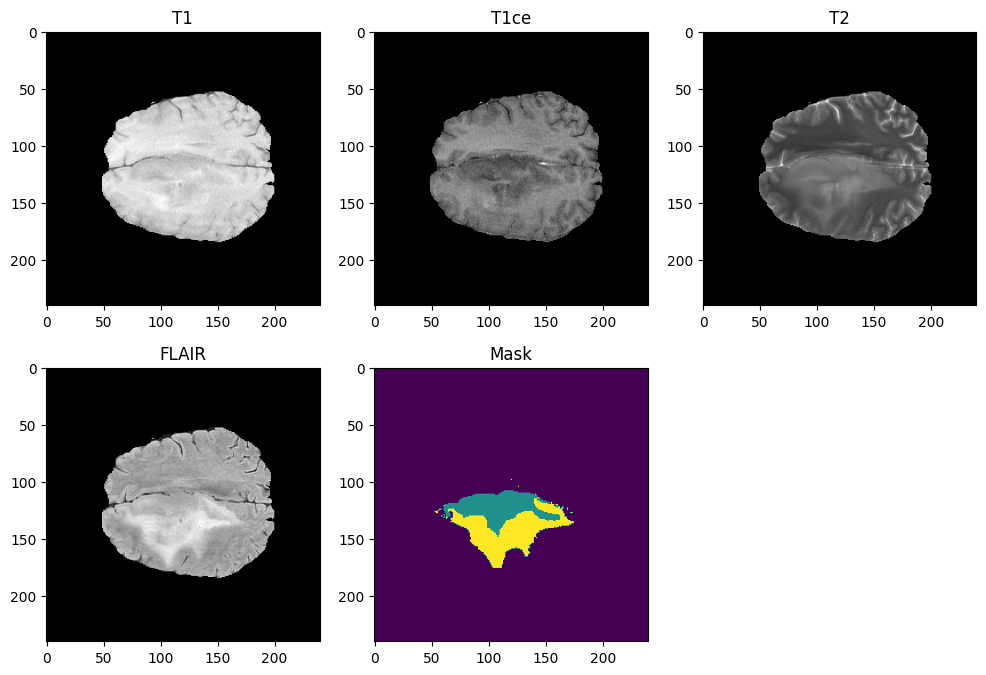

In [9]:
slice = 95

print("Slice Number: " + str(slice))

plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')
plt.show()

The four imaging modalities provide distinct perspectives on the same brain image, each highlighting different features.

**Detailed Description of Each Modality:**
1. **Native (T1):** This modality reveals the structure and composition of various tissue types in the brain. It's instrumental in identifying tumors, cysts, and other abnormalities.
2. **Post-contrast T1-weighted (T1ce, also known as T1Gd):** Similar to T1 images, but enhanced with a contrast agent (Gadolinium), which improves the visibility of abnormalities.
3. **T2-weighted (T2):** This modality highlights the fluid content within brain tissues.
4. **T2-FLAIR (T2 - Fluid Attenuated Inversion Recovery):** This technique suppresses the fluid signals, making it easier to identify lesions that may not be visible on T1 or T2 images. It is particularly useful for detecting lesions in the brain's white matter, which are challenging to spot with other scans.

For medical experts, these four modalities collectively provide a comprehensive view, aiding in precise tumor analysis and confirmation. However, in our artificial intelligence approach, we aim to streamline the process by reducing computational and memory demands. Utilizing only two modalities can achieve this, making the segmentation task faster and more efficient.

To optimize our model, we will exclude the T1 modality since its enhanced counterpart, **T1ce**, provides better clarity. Similarly, we will omit the T2 modality because the fluids it highlights could negatively impact our predictions. Instead, the **T2-FLAIR** modality, which effectively highlights affected regions by suppressing fluid signals, will be more beneficial for our training.

In [10]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


As we can see, the modalities and segmentations have 3 dimensions. Each dimension consists of a series of two-dimensional images, known as slices, which all contain the same number of pixels and are stacked together to create this 3D representation. For instance, in our previous example, we displayed the 95th slice of a certain dimension.

These 3 dimensions correspond to the three spatial dimensions of the image: width, height, and depth. In medical imaging, these dimensions are referred to as the axial (transverse), coronal, and sagittal planes, corresponding to the three main orientations of the human body and, therefore, the human brain.

Here is a quick presentation of these 3 planes:
1. **Axial (Transverse) Plane:** This plane divides the body into upper and lower parts and is perpendicular to the long axis of the body. In brain imaging, an axial slice is a horizontal cut through the brain.
2. **Coronal (Frontal) Plane:** This plane divides the body into front (anterior) and back (posterior) parts. A coronal slice in brain imaging is a vertical cut from one side of the head to the other, dividing the brain into front and back sections.
3. **Sagittal (Lateral) Plane:** This plane divides the body into left and right parts. A sagittal slice in brain imaging is a vertical cut from front to back, dividing the brain into left and right sections.

Understanding these planes is crucial for accurately interpreting medical images and effectively utilizing them in segmentation tasks. Each plane provides a different perspective, helping to localize and identify anatomical structures and abnormalities.

Slice number: 95


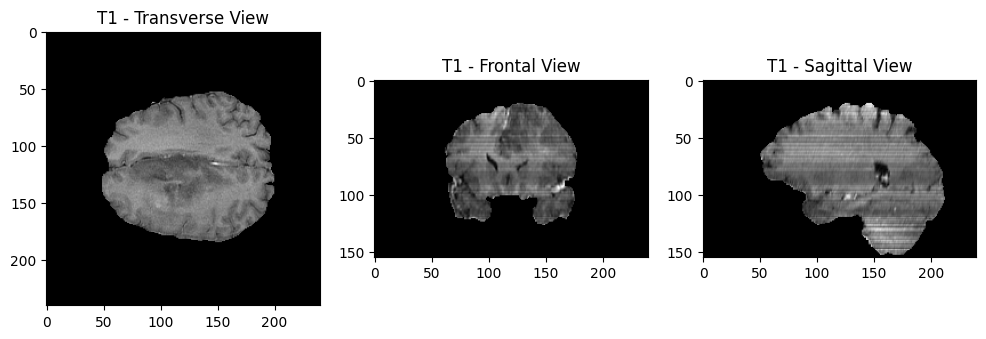

In [11]:
slice = 95

print("Slice number: " + str(slice))

plt.figure(figsize=(12, 8))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Transverse View')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

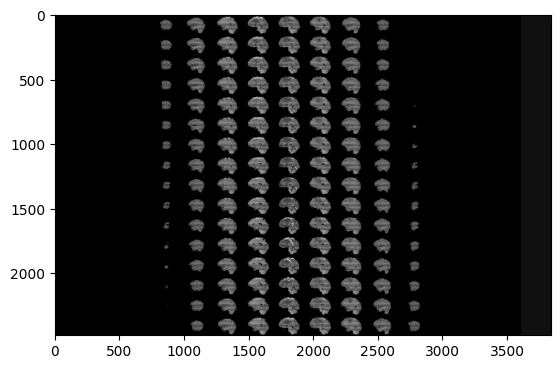

In [12]:
# montage allows us to concatenate multiple images of the same size horizontally and vertically
plt.imshow(rotate(montage(test_image_t1ce[:,:,:]), 90, resize=True), cmap ='gray');

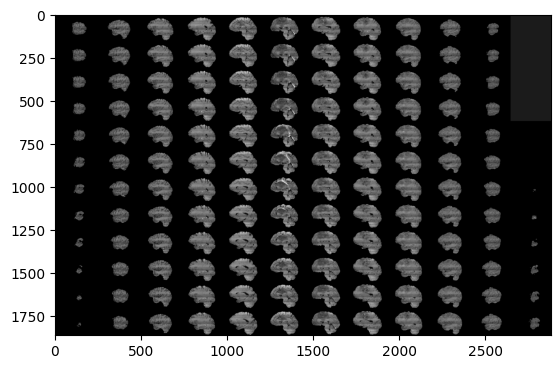

In [13]:
# Skip 50:-50 slices since there is not much to see
plt.imshow(rotate(montage(test_image_t1ce[50:-50,:,:]), 90, resize=True), cmap ='gray');

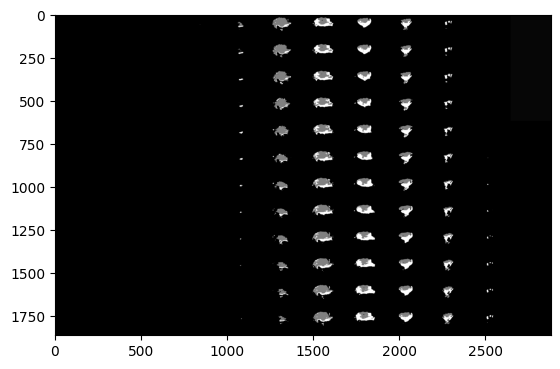

In [14]:
# Skip 50:-50 slices since there is not much to see
plt.imshow(rotate(montage(test_image_seg[50:-50,:,:]), 90, resize=True), cmap ='gray');

Now, let's focus on the segmentations provided by the experts. These segmentations provide critical information about the tumor:

1. **Location:** Identifies the exact location of the tumor in the brain.
2. **Size and Shape:** Measures the tumor's dimensions and form.
3. **Type:** Helps differentiate between various tumor types.
4. **Heterogeneity:** Reveals different components within the tumor (e.g., solid tissue, necrotic areas).
5. **Surrounding Tissue Involvement:** Shows how the tumor interacts with adjacent brain structures.
6. **Cross-Modality Comparison:** Provides a comprehensive view by comparing different imaging modalities.

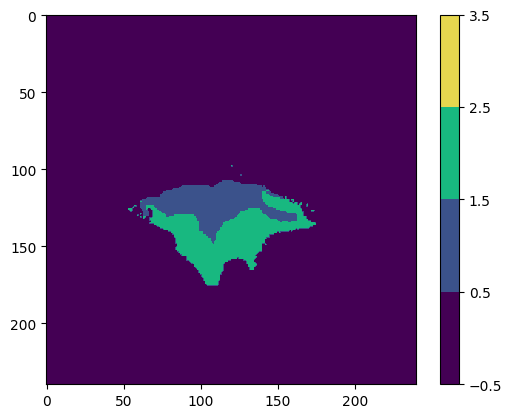

In [15]:
# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# plotting the 95th slice
plt.imshow(test_image_seg[:,:,95], cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

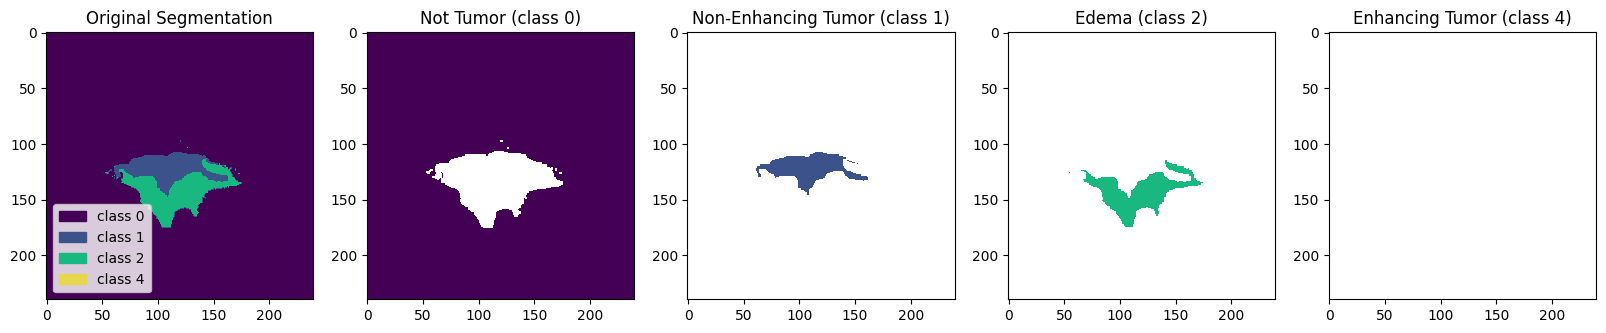

In [16]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

ax[1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

ax[2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')

ax[3].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')

ax[4].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.show()

To summarize our data exploration:
* **Modalities:** Each sample/patient has 4 different modalities (T1, T1CE, T2, and FLAIR), accompanied by a segmentation indicating tumor areas.
* **Selected Modalities:** We will focus on T1CE and FLAIR as they provide complementary information about the brain's anatomy and tissue contrast.
* **3D Images:** Each image is 3D and can be analyzed through 3 different planes composed of 2D slices.
* **Informative Slices:** Many slices contain little or no information. We will use slices in the (50:-50) interval. You can customize this range, but note that changing it may affect training time.
* **Segmentation Classes:** Segmentation images contain 1 to 4 classes. Class 4 will be reassigned to 3 since class 3 is missing.
* **Background Class:** Class 0 (background) is over-represented. Cropping might remove important information, so we will keep the images as they are.

Now that we understand our data better, it's time to prepare for model training.

## **Splitting the Data**

* **Training Set:** 70-80%
* **Validation Set:** 10-15%
* **Testing Set:** 10-15%

We can use random splitting with stratification.

In [17]:
train_and_val_directories = [f.path for f in os.scandir(Train_Path) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 250
Validation length: 74
Test length: 45


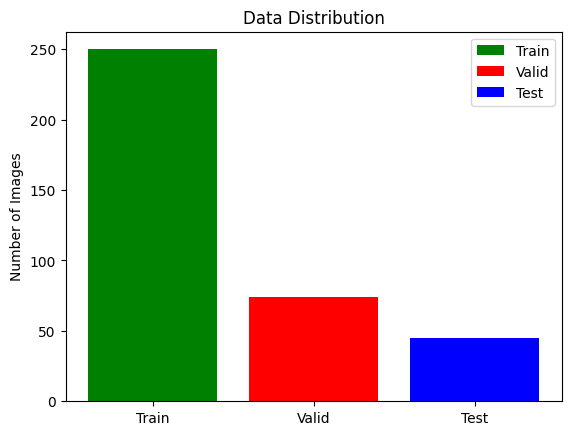

In [18]:
plt.bar(["Train","Valid","Test"],
        [len(train_ids), len(val_ids), len(test_ids)],
        align='center',
        color=[ 'green','red', 'blue'],
        label=["Train", "Valid", "Test"]
       )

plt.legend()

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

## **DataGenerator**
To train a neural network for image segmentation, we need both raw image data (X) and ground truth segmentations (y). This allows the network to learn tumor patterns and make accurate predictions from patient scans. However, directly loading all 3D images can overload system memory and cause shape mismatch errors. Therefore, we use a Data Generator for image preprocessing, which includes several steps:
1. **Retrieve paths:** Obtain the paths for the T1CE and FLAIR modalities (for complementary anatomical and tissue contrast information) and the ground truth segmentation.
2. **Load data:** Load the selected slices (60-135) from these modalities and the corresponding segmentation.
3. **Create arrays:** Form X arrays with the slices from T1CE and FLAIR, and y arrays with the segmentation slices.
4. **Class reassignment:** Assign a value of 3 to all instances of 4 in the mask array to correct the missing class issue.

Additional preprocessing steps include:
* **Axial plane:** Use the axial plane for its square shape (240x240). This enables visualizing predictions across all planes without impact.
* **One-Hot Encoding:** Apply One-Hot Encoding to the y array to convert classes (0 to 3) into a numerical format suitable for neural networks, avoiding any implied hierarchy between classes.
* **Resize images:** Resize each slice from (240x240) to (128x128). This shape is chosen because it is a power of two, fitting well with pooling layers (MaxPooling2D) in CNNs, and balances computational efficiency and information preservation.

While resizing to (256x256) could retain more detail, it significantly increases training time and memory usage. We can choose to train with (256x256) images, but we’ll need to adjust your U-Net architecture accordingly.

Now that we have a clear understanding of our data and preprocessing steps, we can proceed to prepare our model for training.

In [49]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128

In [50]:
class DataGenerator(keras.utils.Sequence):
    """Generates data for Keras."""
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=2, n_channels=2, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        "Denotes the number of batches per epoch (using ceil to include the last partial batch)"
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        "Generate one batch of data"
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        "Updates indexes after each epoch"
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        "Generates data containing batch_size samples"
        batch_size_actual = len(Batch_ids)
        X = np.zeros((batch_size_actual * VOLUME_SLICES, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((batch_size_actual * VOLUME_SLICES, 240, 240), dtype=np.int32)

        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(Train_Path, i)

            flair = nib.load(os.path.join(case_path, f'{i}_flair.nii')).get_fdata()
            t1ce = nib.load(os.path.join(case_path, f'{i}_t1ce.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{i}_seg.nii')).get_fdata()

            for j in range(VOLUME_SLICES):
                slice_index = j + VOLUME_START_AT
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, slice_index], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(t1ce[:, :, slice_index], (IMG_SIZE, IMG_SIZE))
                y[j + VOLUME_SLICES * c] = cv2.resize(seg[:, :, slice_index], (240, 240))

        # Replace label 4 with 3
        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))

        # Normalize X safely (avoid division by zero)
        max_val = np.max(X)
        if max_val != 0:
            X = X / max_val
        return X, Y

# Usage:
training_generator = DataGenerator(train_ids, batch_size=2)
valid_generator = DataGenerator(val_ids, batch_size=2)
test_generator = DataGenerator(test_ids, batch_size=2)

### **Preprocessing Steps Summary**
**Data Generator:** Utilized to process and send data to the neural network without overloading memory.
**Epoch Handling:** For each epoch, the model processes 250 samples from the training dataset.
**Sample Analysis:** Each sample consists of 150 slices (100 slices each from two modalities) resized to (128, 128).
**Data Shapes:**
* **X Array:** Shape (128, 128, 100, 2) for input images.
* **Ground Truth (y):** One-Hot encoded segmentation with shape (100, 128, 128, 4).

This preprocessing setup ensures efficient data handling and preparation for training the neural network.

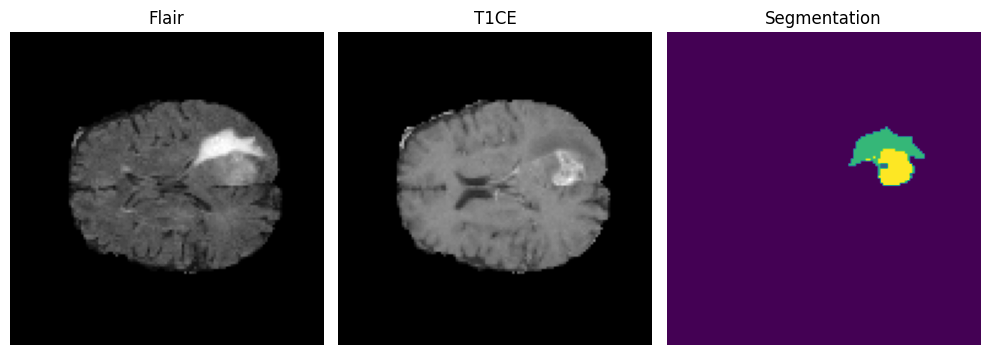

In [51]:
# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation) # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Retrieve the batch from the training generator
X_batch, Y_batch = training_generator[8]

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]
segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

# Extract the 50th slice from Flair, T1CE, and segmentation
slice_index = 60  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the 50th slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)

## **Loss Function and Evaluation Metrics**

**Loss Function**

When training a CNN, selecting an appropriate loss function is crucial for accurately reflecting the network's performance. This function compares the predicted pixels to the ground truth for each patient, guiding the model to update its weights to minimize the loss and improve prediction accuracy.

For multi-class classification problems, a commonly used loss function is categorical cross-entropy. This function measures the difference between the predicted probability distribution of each pixel and the one-hot encoded ground truth values. Additionally, segmentation models sometimes use the Dice loss function, which focuses on the overlap between the predicted and actual segments, further refining the accuracy of the segmentation.

Using these loss functions helps ensure that the model learns effectively and produces accurate segmentations of brain tumors.

In [52]:
# 1. Dice Coefficient for all classes (averaged over 4 classes)
class DiceCoefMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes=4, smooth=1.0, name='dice_coef', **kwargs):
        super(DiceCoefMetric, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.smooth = smooth
        self.total_dice = self.add_weight(name='total_dice', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        dice_sum = 0.0
        for i in range(self.num_classes):
            # Flatten each channel
            y_true_f = tf.reshape(y_true[..., i], [-1])
            y_pred_f = tf.reshape(y_pred[..., i], [-1])
            intersection = tf.reduce_sum(y_true_f * y_pred_f)
            dice = (2. * intersection + self.smooth) / (
                tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + self.smooth)
            dice_sum += dice
        dice_avg = dice_sum / self.num_classes
        self.total_dice.assign_add(dice_avg)
        self.count.assign_add(1.0)
        
    def result(self):
        return self.total_dice / self.count
    
    def reset_states(self):
        self.total_dice.assign(0.0)
        self.count.assign(0.0)

### **Per Class Dice Coefficient Functions**
These functions calculate the Dice coefficient for specific tumor classes in segmentation tasks, helping to measure the model's performance in predicting different tumor regions:

* **dice_coef_necrotic:** Calculates the Dice coefficient for the necrotic (dead tissue) tumor region. It computes the intersection over the sum of squares of the true and predicted values for the necrotic class.
* **dice_coef_edema:** Calculates the Dice coefficient for the edema (swelling) tumor region. It computes the intersection over the sum of squares of the true and predicted values for the edema class.
* **dice_coef_enhancing:** Calculates the Dice coefficient for the enhancing tumor region. It computes the intersection over the sum of squares of the true and predicted values for the enhancing class.

In [53]:
# Define per class evaluation of dice coef
# 2. Dice Coefficient for NECROTIC (channel index 1)
class DiceCoefNecroticMetric(tf.keras.metrics.Metric):
    def __init__(self, smooth=1e-6, name='dice_coef_necrotic', **kwargs):
        super(DiceCoefNecroticMetric, self).__init__(name=name, **kwargs)
        self.smooth = smooth
        self.total_dice = self.add_weight(name='total_dice_necrotic', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_channel = tf.reshape(y_true[..., 1], [-1])
        y_pred_channel = tf.reshape(y_pred[..., 1], [-1])
        intersection = tf.reduce_sum(tf.abs(y_true_channel * y_pred_channel))
        dice = (2. * intersection) / (
            tf.reduce_sum(tf.square(y_true_channel)) +
            tf.reduce_sum(tf.square(y_pred_channel)) + self.smooth)
        self.total_dice.assign_add(dice)
        self.count.assign_add(1.0)
        
    def result(self):
        return self.total_dice / self.count
    
    def reset_states(self):
        self.total_dice.assign(0.0)
        self.count.assign(0.0)

# 3. Dice Coefficient for EDEMA (channel index 2)
class DiceCoefEdemaMetric(tf.keras.metrics.Metric):
    def __init__(self, smooth=1e-6, name='dice_coef_edema', **kwargs):
        super(DiceCoefEdemaMetric, self).__init__(name=name, **kwargs)
        self.smooth = smooth
        self.total_dice = self.add_weight(name='total_dice_edema', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_channel = tf.reshape(y_true[..., 2], [-1])
        y_pred_channel = tf.reshape(y_pred[..., 2], [-1])
        intersection = tf.reduce_sum(y_true_channel * y_pred_channel)
        dice = (2. * intersection) / (
            tf.reduce_sum(tf.square(y_true_channel)) +
            tf.reduce_sum(tf.square(y_pred_channel)) + self.smooth)
        self.total_dice.assign_add(dice)
        self.count.assign_add(1.0)
        
    def result(self):
        return self.total_dice / self.count
    
    def reset_states(self):
        self.total_dice.assign(0.0)
        self.count.assign(0.0)

# 4. Dice Coefficient for ENHANCING (channel index 3)
class DiceCoefEnhancingMetric(tf.keras.metrics.Metric):
    def __init__(self, smooth=1e-6, name='dice_coef_enhancing', **kwargs):
        super(DiceCoefEnhancingMetric, self).__init__(name=name, **kwargs)
        self.smooth = smooth
        self.total_dice = self.add_weight(name='total_dice_enhancing', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_channel = tf.reshape(y_true[..., 3], [-1])
        y_pred_channel = tf.reshape(y_pred[..., 3], [-1])
        intersection = tf.reduce_sum(tf.abs(y_true_channel * y_pred_channel))
        dice = (2. * intersection) / (
            tf.reduce_sum(tf.square(y_true_channel)) +
            tf.reduce_sum(tf.square(y_pred_channel)) + self.smooth)
        self.total_dice.assign_add(dice)
        self.count.assign_add(1.0)
    
    def result(self):
        return self.total_dice / self.count
    
    def reset_states(self):
        self.total_dice.assign(0.0)
        self.count.assign(0.0)

### **Evaluation Metrics**
To effectively monitor the model's performance, we use various evaluation metrics:

* **Accuracy:** Measures the overall proportion of correctly classified pixels. However, it can be misleading with imbalanced datasets like BraTS2020, where the background class is overrepresented.
* **Intersection over Union (IoU):** Measures the overlap between the predicted and ground truth segmentations.
* **Dice Coefficient:** Evaluates the similarity between predicted and ground truth segmentations.
* **Sensitivity (Recall or True Positive Rate):** Measures the proportion of positive ground truth pixels correctly predicted as positive.
* **Precision (Positive Predictive Value):** Measures the proportion of predicted positive pixels that are actually positive.
* **Specificity (True Negative Rate):** Measures the proportion of negative ground truth pixels correctly predicted as negative.

Using these metrics provides a comprehensive assessment of the model’s performance, addressing the limitations of using accuracy alone on imbalanced datasets.

In [54]:
# 5. Precision
class PrecisionMetric(tf.keras.metrics.Metric):
    def __init__(self, name='precision', **kwargs):
        super(PrecisionMetric, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.predicted_positives = self.add_weight(name='pp', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        # Compute true positives and predicted positives after rounding/clipping
        y_true_pred = tf.round(tf.clip_by_value(y_true * y_pred, 0, 1))
        y_pred_rounded = tf.round(tf.clip_by_value(y_pred, 0, 1))
        tp = tf.reduce_sum(y_true_pred)
        pp = tf.reduce_sum(y_pred_rounded)
        self.true_positives.assign_add(tp)
        self.predicted_positives.assign_add(pp)
    
    def result(self):
        return self.true_positives / (self.predicted_positives + tf.keras.backend.epsilon())
    
    def reset_states(self):
        self.true_positives.assign(0.0)
        self.predicted_positives.assign(0.0)

# 6. Sensitivity (Recall)
class SensitivityMetric(tf.keras.metrics.Metric):
    def __init__(self, name='sensitivity', **kwargs):
        super(SensitivityMetric, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.possible_positives = self.add_weight(name='pp', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        y_true_pred = tf.round(tf.clip_by_value(y_true * y_pred, 0, 1))
        y_true_rounded = tf.round(tf.clip_by_value(y_true, 0, 1))
        tp = tf.reduce_sum(y_true_pred)
        pp = tf.reduce_sum(y_true_rounded)
        self.true_positives.assign_add(tp)
        self.possible_positives.assign_add(pp)
    
    def result(self):
        return self.true_positives / (self.possible_positives + tf.keras.backend.epsilon())
    
    def reset_states(self):
        self.true_positives.assign(0.0)
        self.possible_positives.assign(0.0)

# 7. Specificity
class SpecificityMetric(tf.keras.metrics.Metric):
    def __init__(self, name='specificity', **kwargs):
        super(SpecificityMetric, self).__init__(name=name, **kwargs)
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')
        self.possible_negatives = self.add_weight(name='pn', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        one_minus_y_true = 1 - y_true
        one_minus_y_pred = 1 - y_pred
        tn = tf.reduce_sum(tf.round(tf.clip_by_value(one_minus_y_true * one_minus_y_pred, 0, 1)))
        pn = tf.reduce_sum(tf.round(tf.clip_by_value(one_minus_y_true, 0, 1)))
        self.true_negatives.assign_add(tn)
        self.possible_negatives.assign_add(pn)
    
    def result(self):
        return self.true_negatives / (self.possible_negatives + tf.keras.backend.epsilon())
    
    def reset_states(self):
        self.true_negatives.assign(0.0)
        self.possible_negatives.assign(0.0)

## **Define Segmentation Model**

**U-Net**

We will use the U-Net architecture, a convolutional neural network (CNN) specifically designed for biomedical image segmentation. U-Net is particularly effective for segmenting regions of interest that are small and have complex shapes, such as tumors in MRI scans. This architecture was introduced in 2015 by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in their paper U-Net: Convolutional Networks for Biomedical Image Segmentation.

Since the BraTS2020 dataset consists of 3D images, with each image comprising multiple 2D slices in three orthogonal planes, we have two options: using a 2D U-Net or a 3D U-Net.

* **3D U-Net:** More suitable for leveraging the 3D spatial context of the images, reducing the risk of false positives and false negatives from partial information in individual slices. However, it requires more computational resources and memory.
* **2D U-Net:** Faster and requires less memory, advantageous when working with large datasets or limited computational resources.

In practice, it’s useful to try both architectures and compare their performance. We will opt for a 2D U-Net implementation due to its efficiency and lower resource requirements.

In [55]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

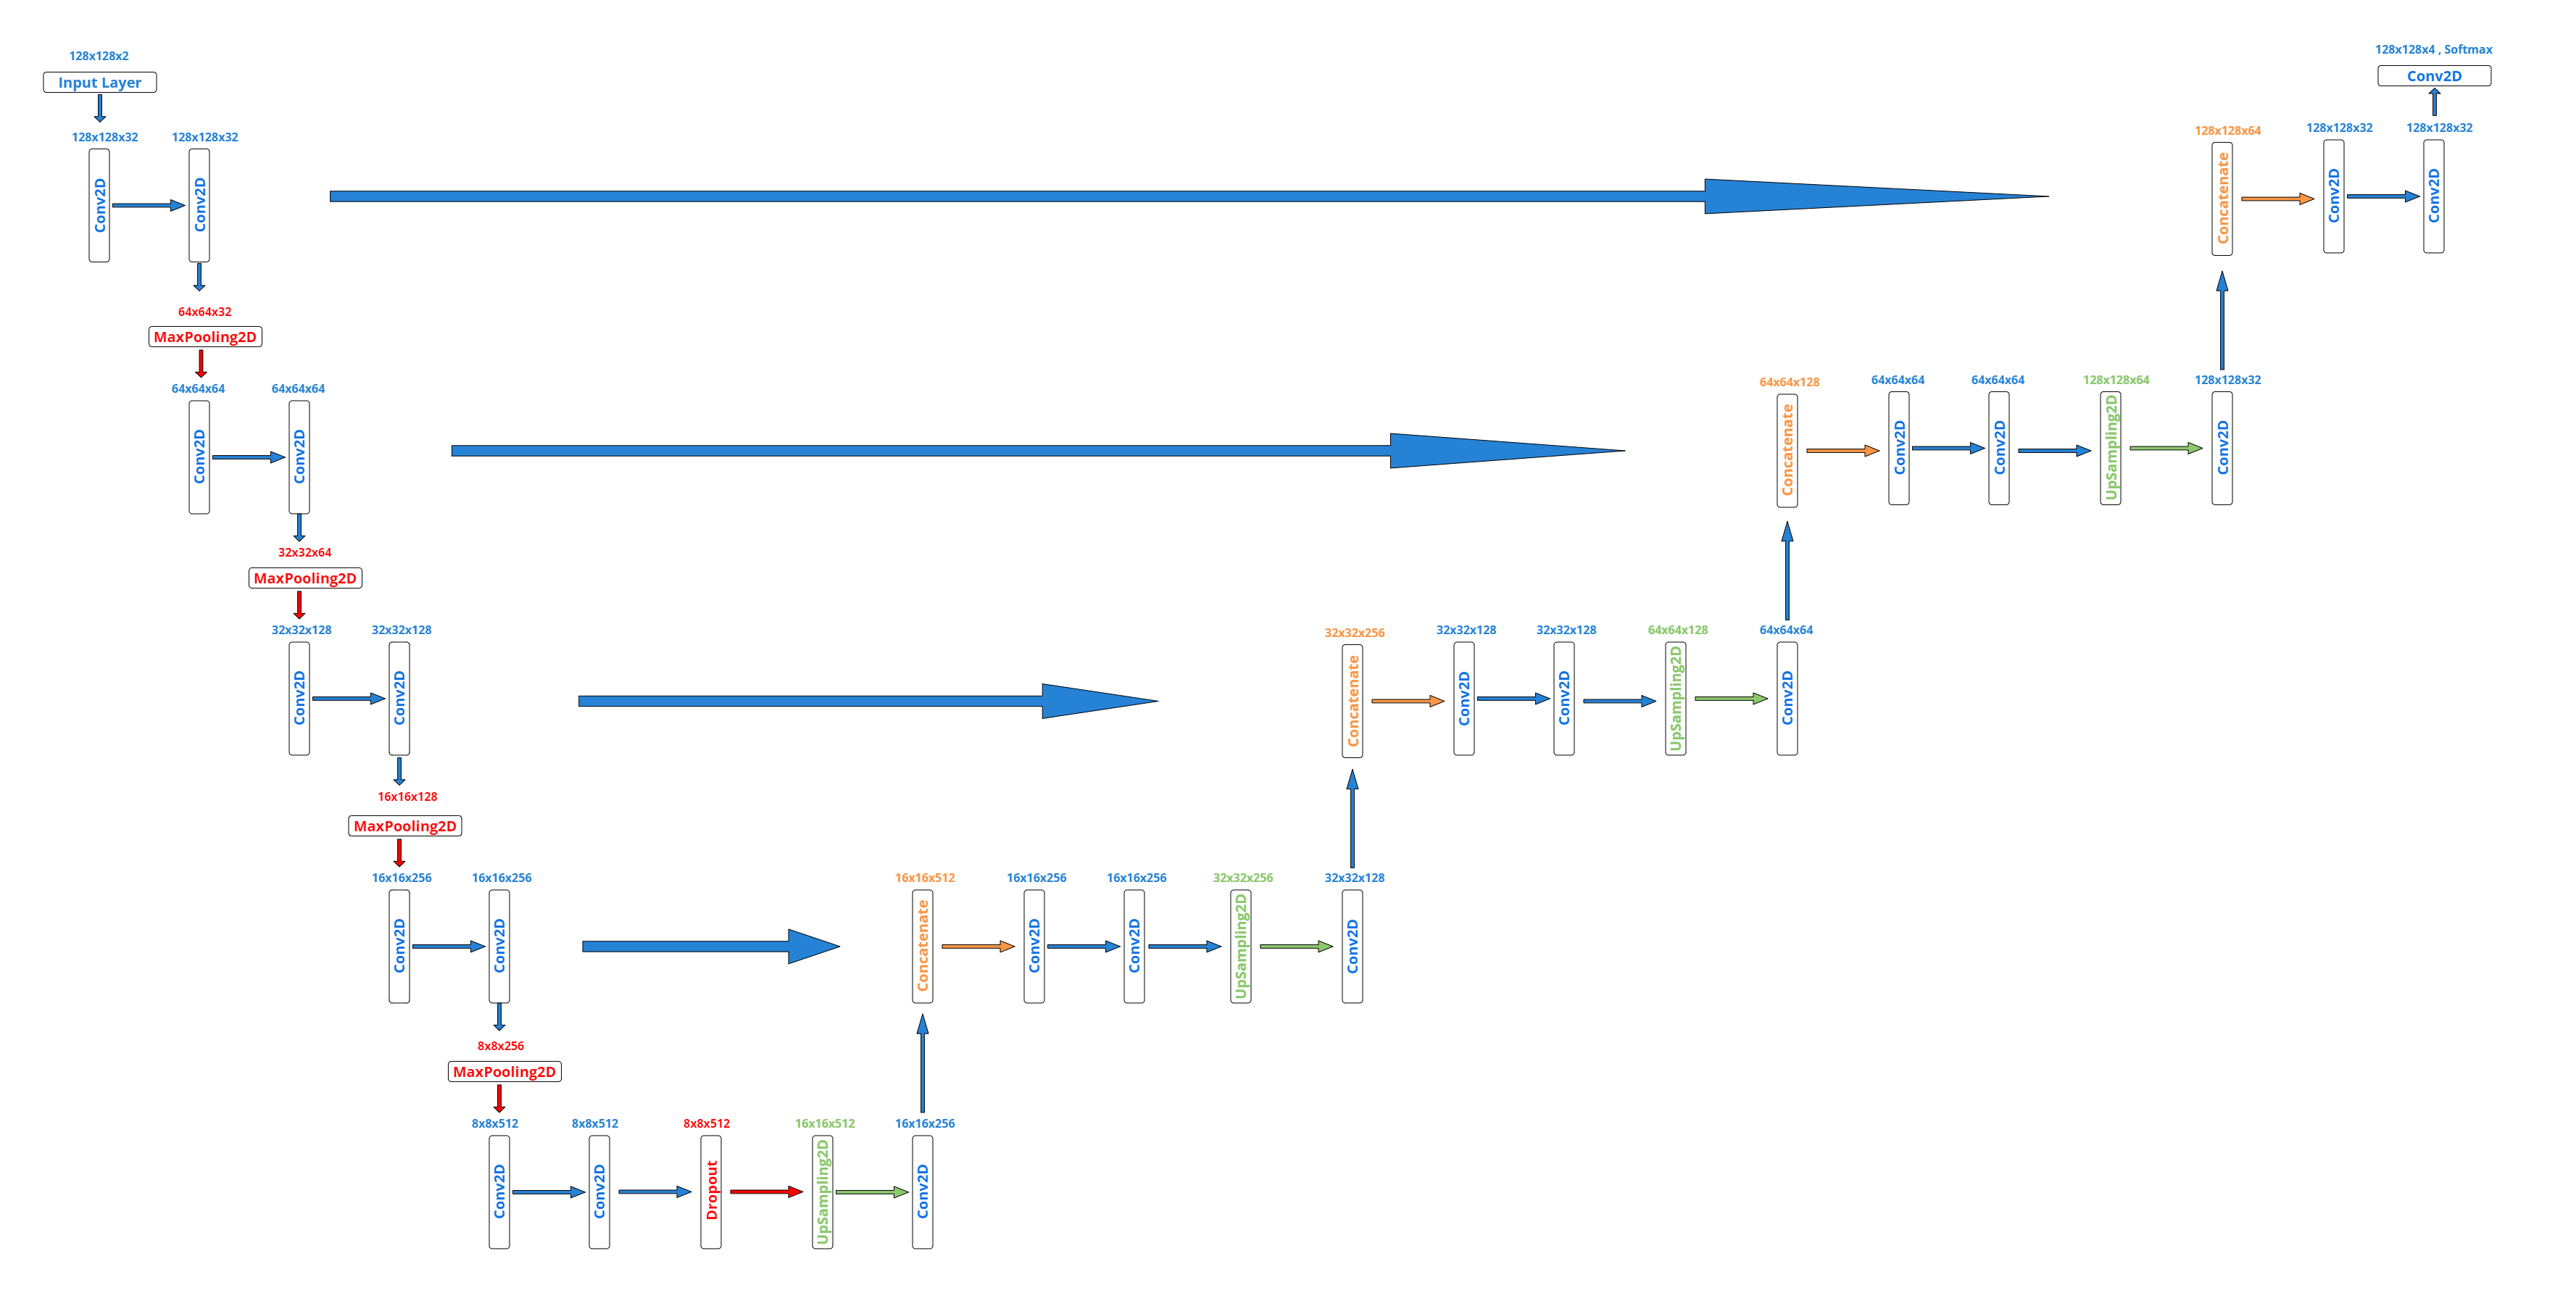

In [56]:
# Build and Plot the Model

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    input_layer = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 2))
    model = build_unet(input_layer, 'he_normal', 0.2)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[
            'accuracy',
            tf.keras.metrics.MeanIoU(num_classes=4),
            DiceCoefMetric(),
            DiceCoefNecroticMetric(),
            DiceCoefEdemaMetric(),
            DiceCoefEnhancingMetric(),
            PrecisionMetric(),
            SensitivityMetric(),
            SpecificityMetric()
        ]
    )

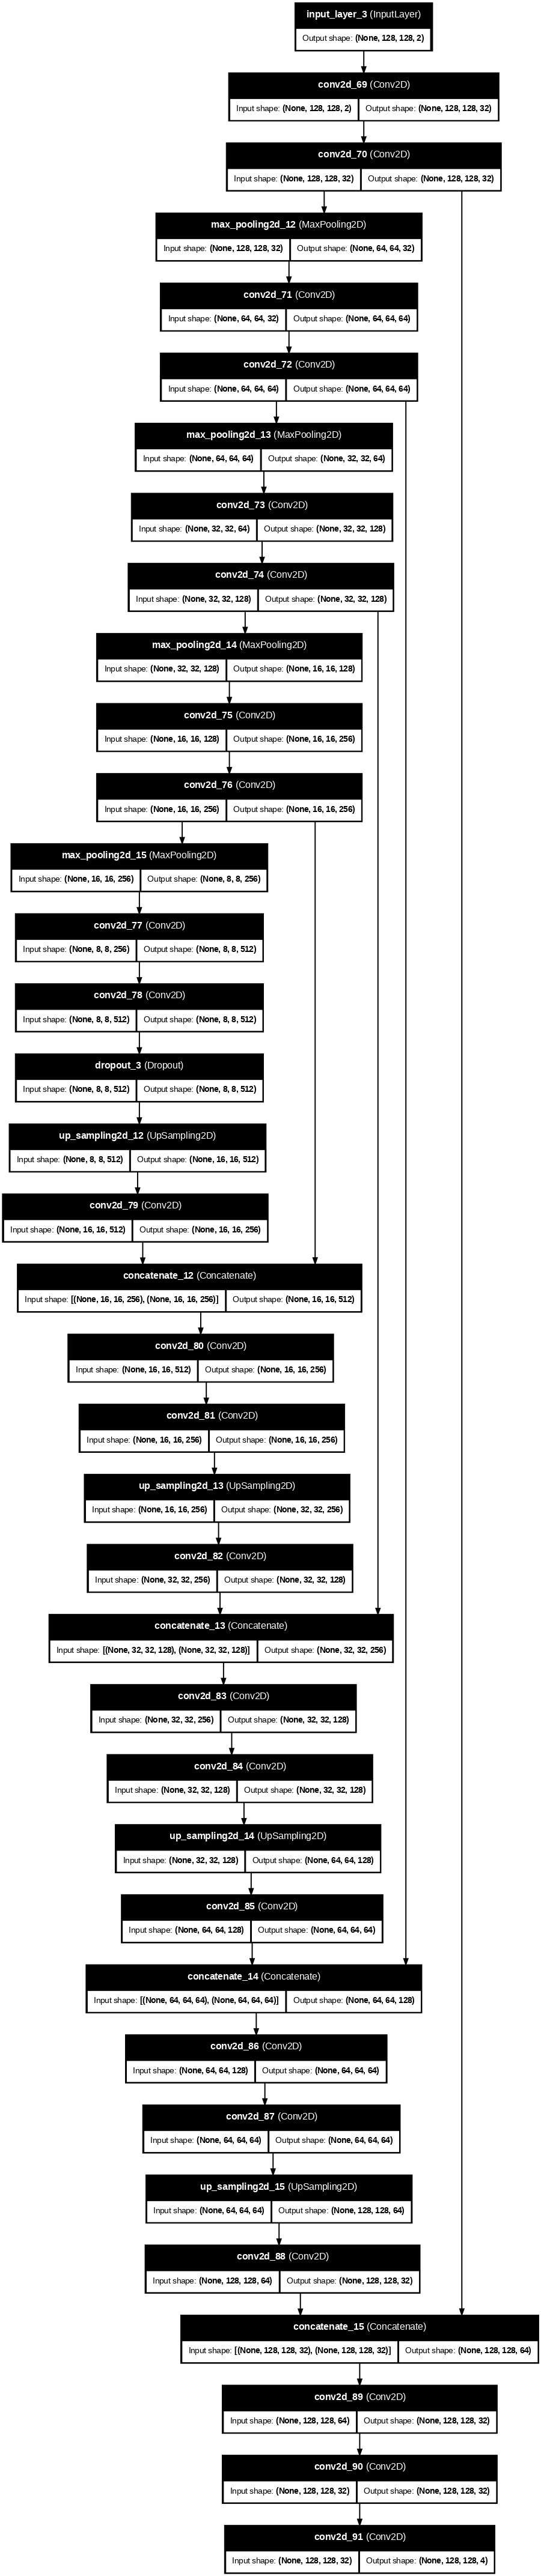

In [57]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [58]:
# Set Up Callbacks
callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                            patience=2, min_lr=0.000001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath='model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
                                verbose=1, save_best_only=True, save_weights_only=True),
      CSVLogger('training.log', separator=',', append=False)
    ]

## **Train and Save the Model**

We are now ready to train the deep neural network using the .fit() keras method. We will pass our callbacks to this method to be executed during the training process which will last for 35 epochs.

In [ ]:
history =  model.fit(training_generator,
                    epochs=30,
                    steps_per_epoch=len(training_generator),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )

model.save("/kaggle/working/UNet_idev1_MRI.keras")

Epoch 1/30
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.9060 - dice_coef: 0.2335 - dice_coef_edema: 0.0648 - dice_coef_enhancing: 0.0228 - dice_coef_necrotic: 0.0244 - loss: 0.3492 - mean_io_u_3: 0.4056 - precision: 0.9289 - sensitivity: 0.8359 - specificity: 0.9879
Epoch 1: val_loss improved from inf to 0.08307, saving model to model_.01-0.083074.weights.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9065 - dice_coef: 0.2337 - dice_coef_edema: 0.0651 - dice_coef_enhancing: 0.0229 - dice_coef_necrotic: 0.0246 - loss: 0.3477 - mean_io_u_3: 0.4056 - precision: 0.9293 - sensitivity: 0.8368 - specificity: 0.9879 - val_accuracy: 0.9835 - val_dice_coef: 0.2568 - val_dice_coef_edema: 0.0318 - val_dice_coef_enhancing: 0.0058 - val_dice_coef_necrotic: 0.0127 - val_loss: 0.0831 - val_mean_io_u_3: 0.4092 - val_precision: 0.9835 - val_sensitivity: 0.9835 - val_specificity: 0.9945 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 880ms/step - accuracy: 0.984

In [ ]:
model.save("/kaggle/working/UNet_idev1_MRI.keras")

## **Load Trained Model**
We will load our trained neural network model using Keras. The ``load_model`` method allows us to reload the saved model, including custom metrics and loss functions we defined during training.

We specify the path to our saved model and provide a dictionary of custom_objects to ensure that our custom metrics and loss functions are correctly recognized by Keras. Setting compile=False allows us to load the model architecture and weights without compiling it immediately, giving us the flexibility to adjust compilation settings if needed.

In [ ]:
model = keras.models.load_model('/kaggle/working/UNet_idev1_MRI.keras',
                                   custom_objects={"accuracy" : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef" : dice_coef,
                                                   "precision" : precision,
                                                   "sensitivity" :sensitivity,
                                                   "specificity" :specificity,
                                                   "dice_coef_necrotic" : dice_coef_necrotic,
                                                   "dice_coef_edema" : dice_coef_edema,
                                                   "dice_coef_enhancing" : dice_coef_enhancing
                                                  }, compile=False)

## **Metrics Analysis**
Now that the training is complete, we can examine the CSVLogger callback to gain insights into the training process and our model's performance. The CSVLogger records metrics such as accuracy, loss, Dice coefficient, and Mean IoU for each epoch, allowing us to track the model’s progress over time. By analyzing this log, we can identify trends, assess the effectiveness of our training strategy, and make informed decisions for future improvements. This thorough review ensures our model is performing optimally and ready for deployment.

In [ ]:
column_names = ["epoch", "accuracy", "val_accuracy", "loss", "val_loss",
                "dice_coef", "val_dice_coef", "mean_io_u", "val_mean_io_u"]  # Modify based on actual data
history = pd.read_csv('/kaggle/working/training.log', sep=',', engine='python', names=column_names)

In [ ]:
print(history.columns)

In [ ]:
column_names = ["epoch","accuracy","dice_coef","dice_coef_edema","dice_coef_enhancing","dice_coef_necrotic","learning_rate","loss","mean_io_u","precision","sensitivity","specificity","val_accuracy","val_dice_coef","val_dice_coef_edema","val_dice_coef_enhancing","val_dice_coef_necrotic","val_loss","val_mean_io_u","val_precision","val_sensitivity","val_specificity"]  # Modify based on actual data
history = pd.read_csv('/kaggle/working/training.log', sep=',', names=column_names)

hist=history

acc=hist["accuracy"]
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [ ]:
import tensorflow

# Compile a model and load our saved weights
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

best_saved_model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

best_saved_model.load_weights('/kaggle/working/model_.28-0.031614.weights.h5')

In [ ]:
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)

In [ ]:
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)
def showPredictsById(case, start_slice = 60):
    path = f"/kaggle/input/mlma-project/BraTS2020_TrainingData/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes predicted')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()

In [ ]:
showPredictsById(case=test_ids[0][-3:])

In [ ]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X/np.max(X), verbose=1)
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)

    # Get path of this patient
    random_sample_path = os.path.join(Train_Path, random_sample, random_sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    axstest[1].imshow(all, cmap, norm)
    axstest[1].set_title('Predicted Segmentation - all classes')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - Not Tumor')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - Necrotic/Core')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - Edema')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - Enhancing')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

In [ ]:
show_predicted_segmentations(test_ids, 45, cmap, norm)

In [ ]:
case = test_ids[3][-3:]
path = f"/kaggle/input/mlma-project/BraTS2020_TrainingData/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)

core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]

i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'

gt[gt != eval_class] = 1 # use only one class for per class evaluation

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [ ]:
# Evaluate the model on the test data
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity", "Dice coef Necrotic", "Dice coef Edema", "Dice coef Enhancing"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

In [ ]:
# Print the full lists of subject IDs for each dataset
print("Train subject IDs:", train_ids)
print("Validation subject IDs:", val_ids)
print("Test subject IDs:", test_ids)

# Now, get the batch IDs for each generator by using their internal indexes.
# (Since 'on_epoch_end()' already sets 'indexes', we can use that.)

# For the training generator:
print("\nBatch IDs in Training Generator:")
for i in range(len(training_generator)):
    # Calculate indices for the i-th batch
    batch_indices = training_generator.indexes[i * training_generator.batch_size:(i+1) * training_generator.batch_size]
    # Get corresponding subject IDs
    batch_ids = [training_generator.list_IDs[idx] for idx in batch_indices]
    print(f"Batch {i}:", batch_ids)

# For the validation generator:
print("\nBatch IDs in Validation Generator:")
for i in range(len(valid_generator)):
    batch_indices = valid_generator.indexes[i * valid_generator.batch_size:(i+1) * valid_generator.batch_size]
    batch_ids = [valid_generator.list_IDs[idx] for idx in batch_indices]
    print(f"Batch {i}:", batch_ids)

# For the test generator:
print("\nBatch IDs in Test Generator:")
for i in range(len(test_generator)):
    batch_indices = test_generator.indexes[i * test_generator.batch_size:(i+1) * test_generator.batch_size]
    batch_ids = [test_generator.list_IDs[idx] for idx in batch_indices]
    print(f"Batch {i}:", batch_ids)

In [ ]:
import csv

# Save training subject IDs
with open('train_subjects.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Subject ID'])
    for subject in train_ids:
        writer.writerow([subject])

# Save validation subject IDs
with open('validation_subjects.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Subject ID'])
    for subject in val_ids:
        writer.writerow([subject])

# Save test subject IDs
with open('test_subjects.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Subject ID'])
    for subject in test_ids:
        writer.writerow([subject])

# For training generator
with open('train_batches.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Batch Index', 'Subject IDs'])
    for i in range(len(training_generator)):
        batch_indices = training_generator.indexes[i * training_generator.batch_size:(i+1) * training_generator.batch_size]
        batch_ids = [training_generator.list_IDs[idx] for idx in batch_indices]
        writer.writerow([i, ','.join(batch_ids)])

# For validation generator
with open('validation_batches.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Batch Index', 'Subject IDs'])
    for i in range(len(valid_generator)):
        batch_indices = valid_generator.indexes[i * valid_generator.batch_size:(i+1) * valid_generator.batch_size]
        batch_ids = [valid_generator.list_IDs[idx] for idx in batch_indices]
        writer.writerow([i, ','.join(batch_ids)])

# For test generator
with open('test_batches.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Batch Index', 'Subject IDs'])
    for i in range(len(test_generator)):
        batch_indices = test_generator.indexes[i * test_generator.batch_size:(i+1) * test_generator.batch_size]
        batch_ids = [test_generator.list_IDs[idx] for idx in batch_indices]
        writer.writerow([i, ','.join(batch_ids)])